# Labeling Disaster-Related Messages

<img src='./images/wordcloud.png'>

### Problem
Given text data of disaster-related messages and news bulletins (English / English translation), can we correctly assign labels (tags) to the message?

- Each message can have multiple tags (or no tags) associated with it.

- The task will involve **Natural Language Processing** (*NLP*) analysis.

https://appen.com/datasets/combined-disaster-response-data/

### Objective
Our goal is to create a model that can interpret and label a message using **Natural Language Processing**. There are **37** important labels that a message can have (for example if the message is *requesting medical help* or *offering aid*).

### Success Criteria
It is our goal to build a model that can correctly assign as many labels as possible to each message / bulletin.
We will be using `f1-score` and `hamming_loss` to assess our models.

#### F1-Score
> *Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.*
>
> *The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall.*
> https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

> ${Recall} = \frac{TP}{TP + FN}$
> 
> ${Precision} = \frac{TP}{TP + FN}$
> 
> $\LARGE {f_1} = 2 \times \frac{precision \times recall}{precision + recall}$

We will be using a mean f1-score (`average='samples'`) which assesses the f1-score of each sample separately and averages them.

```python
>>> y_true = np.array([[1,1,1,1],
>>>                    [1,0,0,0]])
>>> y_pred = np.array([[0,1,1,0],
>>>                    [1,0,0,0]])
>>>
>>> # 2/4 (0.5) true positives correctly labeled on the first entry
>>> # 1/1 (1.0) true positives correctly labeled on the second entry
>>> # 1.0 * 0.5 = 0.75
>>> recall_score(y_true, y_pred, average='samples')
0.75

>>> # Every positive label is correct on both samples
>>> precision_score(y_true, y_pred, average='samples')
1.0

>>> # Sample 1: 2 * ((0.5 * 1) / (0.5 + 1))
>>> # 0.667
>>> # Sample 2: 2 * ((1 * 1) / (1 + 1))
>>> # 1.0
>>> # (0.667 + 1.0) / 2 = 0.8335
>>> f1_score(y_true, y_pred, average='samples')
0.8333333333333333
```

***

#### Hamming Loss
> **Hamming Loss:** The percentage of labels that are incorrectly predicted (or the inverse or an `accuracy_score`). 
> 
> $\LARGE L_{Hamming}(y, \hat{y}) = \frac{1}{n_\text{labels}} \sum_{j=0}^{n_\text{labels} - 1} 1(\hat{y}_j \not= y_j)$
> 
> *https://scikit-learn.org/stable/modules/model_evaluation.html#hamming-loss*

*When assessing multi-label predictions, an `accuracy_score` will return an overly-strict assessment of each row.*

*Either every label is correct (`acc=1`) or there are any number of mis-labels (`acc=0`)).*

Hamming loss will show the number of overall incorrect labels, thereby preferring a prediction with 2/3 correct labels over one with 0/3 correct labels.

```python
>>> y_true = np.array([[1,1,1,1],
>>>                    [1,0,0,0]])
>>> y_pred = np.array([[0,1,1,0],
>>>                    [1,0,0,0]])
>>>
>>> # 2/8 total mislabeled. (0.25)
>>> hamming_loss(y_true, y_pred) 
0.25
```

- **Note**: Since we are measuring a loss, the best model will have the *lowest* score.

***

#### Binary Cross-Entropy
> **Binary Cross-Entropy** (*log-loss*): Similar to the Hamming Loss function, this measures the loss based on how wrong the model's predictions are.
>
> However, Binary Cross-Entropy is able to measure continuous entries rather than just binary.

$\LARGE {cross entropy} = -\sum_{c=1}^My_{o,c}\log(p_{o,c})$

> *Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.*
>
> *https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html*

### Imports

In [1]:
import sys

# the ./support dir contains disaster_response.py
sys.path.append('./support')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import os
import html
import string
from IPython.display import clear_output

from sklearn.metrics import (f1_score, recall_score, 
                             precision_score, hamming_loss)

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras import (
    layers, models, initializers, regularizers, constraints, optimizers
)
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint

import spacy

import kerastuner as kt

# Custom functions and classes for this project.
import disaster_response as dis 

In [3]:
# Check that GloVe model exists in the correct directory.
dis.check_for_glove()

# Plot formatting.
plt.style.use(['ggplot', 'seaborn-talk'])

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94'
}

********************************************************************************
*                         SUCCESS - GloVe Model Found                          *
********************************************************************************


## Data Understanding
### Load in data.

In [4]:
# Checking that the necessary files are in the default directory.
os.listdir('./data/')

['.ipynb_checkpoints',
 'column_descriptions.csv',
 'disaster_response_messages_test.csv',
 'disaster_response_messages_training.csv',
 'disaster_response_messages_validation.csv']

In [5]:
# Load in data.
dw = dis.DataWarehouse()

********************************************************************************
*                           Data loaded sucessfully.                           *
********************************************************************************
********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Training Data:
	(21046, 42)
Val Data:
	(2573, 42)
Test Data:
	(2629, 42)

Column Descriptions:
	(20, 1)


### Explore data.

In [6]:
dw.train.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [7]:
dw.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
id                        21046 non-null int64
split                     21046 non-null object
message                   21046 non-null object
original                  8191 non-null object
genre                     21046 non-null object
related                   21046 non-null int64
PII                       21046 non-null int64
request                   21046 non-null int64
offer                     21046 non-null int64
aid_related               21046 non-null int64
medical_help              21046 non-null int64
medical_products          21046 non-null int64
search_and_rescue         21046 non-null int64
security                  21046 non-null int64
military                  21046 non-null int64
child_alone               21046 non-null int64
water                     21046 non-null int64
food                      21046 non-null int64
shelter                   21046 non-null i

- There are a couple columns that are strings (that we'll be working with with NLP).
```python
['message', 'genre']
```
- There are many missing values in the `original` column.
- There is an `id` column which can be dropped.
- There are 37 potential target columns (labels) that are binary.

In [8]:
dw.train['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [9]:
# Check the integrity of the `message` column when the `original` is missing.
dw.train[dw.train['original'].isna()]['message'].head()

5973             NOTES: It mark as not enough information
7956    My thoughts and prayers go out to all the live...
7957    lilithia yes 5.2 magnitude earthquake hit mani...
7958    RT TheNewsBlotter RT caribnews On Call Interna...
7959    Most Eureka homeowners won&#39 t collect on qu...
Name: message, dtype: object

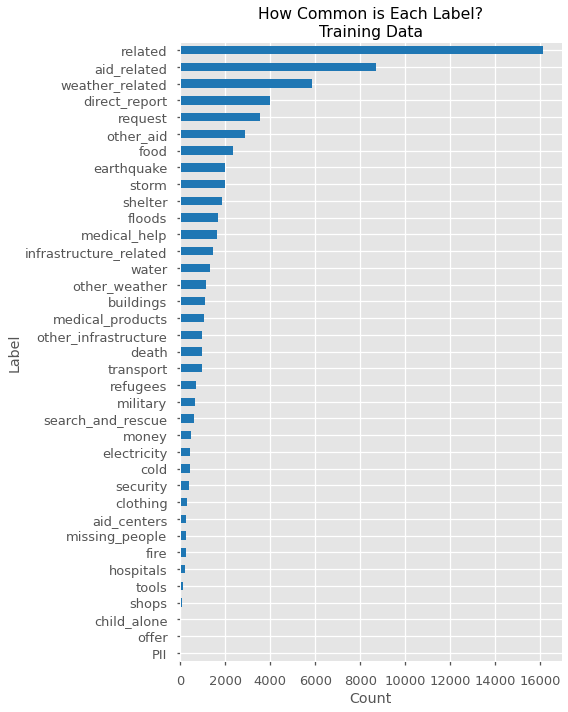

In [10]:
# Plot label-counts within the training data.
label_counts = dw.train[dw.target_columns].sum().sort_values()

fig, ax = plt.subplots(figsize=(8, 10))
label_counts.plot(kind='barh', color=COLORS['blue'])
ax.set(title='How Common is Each Label?\nTraining Data',
       ylabel='Label',
       xlabel='Count')
fig.tight_layout()

- Some labels are non-existent in the training data which should prove to be a problem.

### Understand what the columns mean.

In [11]:
dw.column_descriptions

,Description
Column,
id,Unique ID for each individual row
split,"Test, tune, validation split"
message,English text of actual messages related to dis...
original,Text of column 3 in native language as origina...
genre,"Type of message, including direct messages, so..."
related,"Is the message disaster related? 1= yes, 2=no"
PII,"Does the message contain PII? 1= yes, 2=no"
request,"Does the message contain a request? 1= yes, 2=no"
offer,"Does the message contain an offer? 1= yes, 2=no"


- This is pretty predictable. The `message` column has text data (sometimes english translated). Each of the label columns is binary.
  - There is a typo in the label column descriptions: `{1: 'yes', 0: 'no'}`

### What kind of cleaning is required?
1. Drop columns `['id', 'split']`.
2. Examine the text for abnormalities.
3. Combine all the text into one column.
4. Process the text data.
 1. Load in a pre-trained GloVe model. (https://nlp.stanford.edu/projects/glove/)
 2. Fit text on the GloVe model into matrix.

## Data Preparation
### Data cleanup / merging / prep for modeling.

In [12]:
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 42)
Processed Val Data:
	(2573, 42)
Processed Test Data:
	(2629, 42)


In [13]:
# Drop unnecessary columns.
dw.drop_column(['id', 'split'])

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['id', 'split']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 40)
Processed Val Data:
	(2573, 40)
Processed Test Data:
	(2629, 40)


#### Examine abnormalities and clean text.

In [14]:
# Clean HTML escape characters (such as ``&#39`` which maps to an apostrophe).
example_string = [string for string in dw.train['message']
                   if '&#' in string][0]
print(example_string)
print(html.unescape(example_string))

Most Eureka homeowners won&#39 t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT
Most Eureka homeowners won' t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT


In [15]:
dw.map_to_all('message', html.unescape)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Combine all text into one column. 

In [16]:
# Which columns are we combining?
dw.processed_train.select_dtypes('O').columns

Index(['message', 'original', 'genre'], dtype='object')

In [17]:
# Combine genre with message.
for df in dw.processed_data:
    df['all_text'] = df['message'] + ' ' + df['genre']
    
dw.processed_train['all_text'].head()

0    Weather update - a cold front from Cuba that c...
1       Is the Hurricane over or is it not over direct
2    says: west side of Haiti, rest of the country ...
3        Information about the National Palace- direct
4                Storm at sacred heart of jesus direct
Name: all_text, dtype: object

#### Tokenize lower-case text.

In [18]:
# Set new column as copy to maintain original integrity.
for df in dw.processed_data:
    df['all_text_tokenized'] = df['all_text'].copy()

In [19]:
# Map all text to lower case.
dw.map_to_all('all_text_tokenized', lambda x: x.lower())

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [20]:
# Tokenize text into lists.
dw.map_to_all('all_text_tokenized', word_tokenize)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [21]:
# Stopwords list.
sw = stopwords.words('english')
sw += string.digits
sw += string.punctuation

not_in_sw = lambda x: [word for word in x if word not in sw]

# Remove stopwords and punctuation.
dw.map_to_all('all_text_tokenized', not_in_sw)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [22]:
dw.processed_train['all_text_tokenized'][0]

['weather',
 'update',
 'cold',
 'front',
 'cuba',
 'could',
 'pass',
 'haiti',
 'direct']

#### Set DataWarehouse's column structure.

In [23]:
dw.predictive_columns = 'all_text_tokenized'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


#### Inspect target_columns.

In [24]:
for col in dw.target_columns:
    vc = dw.processed_train[col].value_counts()
    if len(vc) != 2:
        display(vc)

1    15795
0     5083
2      168
Name: related, dtype: int64

0    21046
Name: PII, dtype: int64

0    21046
Name: offer, dtype: int64

0    21046
Name: child_alone, dtype: int64

*There is an abnormality with the `'related'` column - there are three values.* 

*Since the target should be binary, I'm going to set the few '2' entries to 0 (ie: not related).*

In [25]:
# Set the related column to binary.
dw.map_to_all('related', lambda x: 0 if x == 0 else 1)

********************************************************************************
*                                   Success                                    *
********************************************************************************


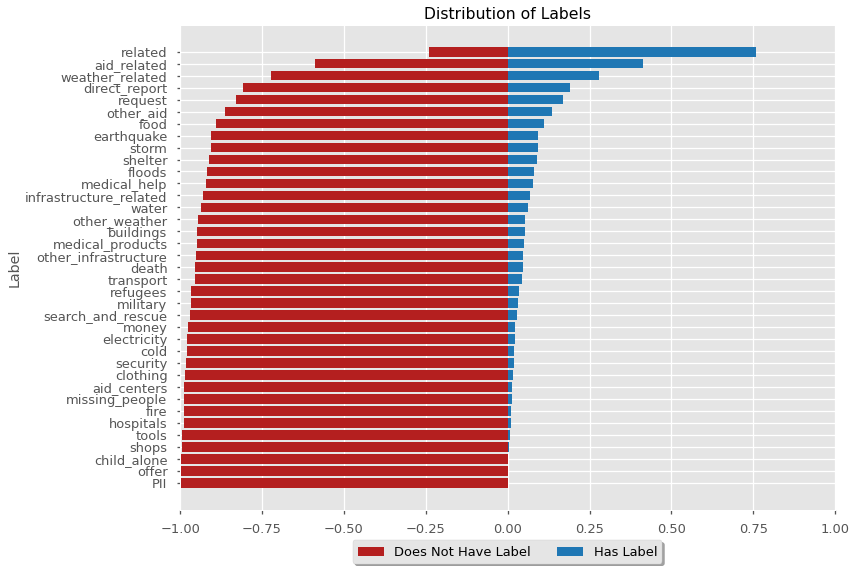

In [26]:
# Plot stacked percentage bar chart.
dw.plot_label_distribution('train',
                           normalize=True,
                           figsize=(12,8),
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'])

*Most of the labels are very rare (or non-existent).*

*For handling these, I'm going to ignore labels that show up in less than 2.5% of entries.*

In [27]:
# Drop labels which are present in less than 2.5% of training data.
twoptfive_percent = len(dw.Y_train()) * 0.025
total_labels = dw.processed_train[dw.target_columns].sum()
less_than_twoptfive_percent = total_labels[total_labels < twoptfive_percent]
less_than_twoptfive_percent

PII                 0
offer               0
security          402
child_alone         0
clothing          323
money             487
missing_people    252
electricity       449
tools             140
hospitals         228
shops              99
aid_centers       258
fire              239
cold              425
dtype: int64

In [28]:
# Drop columns.
dw.drop_column(list(less_than_twoptfive_percent.index))

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['PII', 'offer', 'security', 'child_alone', 'clothing', 'money', 'missing_people', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire', 'cold']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 28)
Processed Val Data:
	(2573, 28)
Processed Test Data:
	(2629, 28)


In [29]:
print('Target Columns:\n\t', len(dw.target_columns))

Target Columns:
	 23


#### Are there entries with no labels?

In [30]:
num_labels_train = dw.processed_train[dw.target_columns].sum(axis=1)
num_labels_val = dw.processed_val[dw.target_columns].sum(axis=1)

eq_0_train = num_labels_train[num_labels_train == 0]
eq_0_val = num_labels_val[num_labels_val == 0]

num_no_label_train = len(eq_0_train)
num_no_label_val = len(eq_0_val)
print('Entries with no labels:')
print('Training:  ', 
      num_no_label_train,
      f'\t{round(num_no_label_train/len(num_labels_train), 5) * 100}%')
print('Validation:', 
      num_no_label_val,
      f'\t{round(num_no_label_val/len(num_labels_val), 5) * 100}%')

Entries with no labels:
Training:   5083 	24.152%
Validation: 632 	24.563%


In [31]:
# Sample text from no-label data.
idx_lst = eq_0_train.index[:10]
samples = dw.processed_train.loc[idx_lst][dw.predictive_columns]
for i, lst in zip(idx_lst, samples.values):
    print(f'{i}\t{" ".join(lst)}')

3	information national palace- direct
6	would like receive messages thank direct
8	petionville need information regarding 4636 direct
14	n't understand use thing 4636. direct
21	tell service direct
24	good evening radio one please would like information tiyous direct
26	'm n't find person needed send pant phone direct
43	'm listening miraguan asking government take change one gallon gas 80. direct
54	happy hear god religious hyme direct
65	would like know food distributed direct


In [32]:
# Create label - no_label.
for df in dw.processed_data:
    df['no_label'] = (df[dw.target_columns].sum(axis=1) == 0).astype(int)
    
dw.processed_train['no_label'].head()

0    0
1    0
2    0
3    1
4    0
Name: no_label, dtype: int32

In [33]:
# Append target_columns.
dw.target_columns.append('no_label')

dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 ['related', 'request', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'military', 'water', 'food', 'shelter', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'earthquake', 'other_weather', 'direct_report', 'no_label']


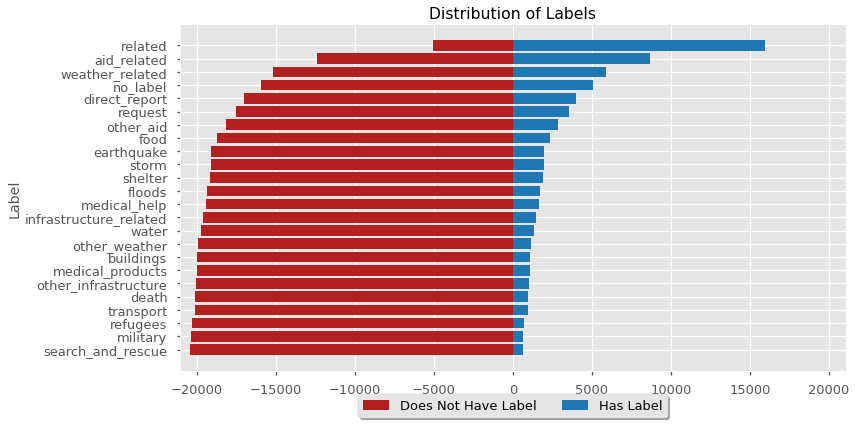

In [34]:
dw.plot_label_distribution('train',
                           figsize=(12, 6),
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'])

### Load GloVe.

In [35]:
# Set up total_vocabulary set with all unique words in all texts.
total_vocab = set(
    [word for entry in dw.processed_train[dw.predictive_columns].values 
     for word in entry]
)
print('Total unique words:', len(total_vocab))

Total unique words: 35424


In [36]:
# Load in pretrained GloVe model.
glove = {}

with open('./models/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0].decode('utf-8')
        if word in total_vocab:
            word_vector = np.array(line_split[1:], dtype=np.float32)
            glove[word] = word_vector
            
print('Total words loaded from GloVe:', len(glove))

Total words loaded from GloVe: 24792


## EDA

### Length of Messages.

In [39]:
# Find length of each message.
num_words = dw.processed_train[
    dw.predictive_columns].map(lambda x: len(x))

In [42]:
n_words_mean = num_words.mean()
n_words_std = num_words.std()

In [63]:
num_words >= n_words_mean - (n_words_std*3)
num_words <= n_words_mean + (n_words_std*3)

526       66
1007      62
2302      47
6967      53
8038      50
        ... 
20366    153
20480     45
20661     54
20740     59
21031     47
Name: all_text_tokenized, Length: 197, dtype: int64

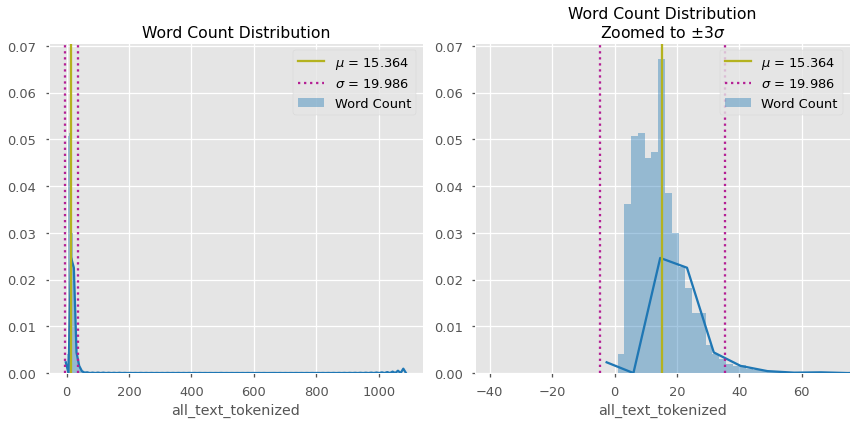

In [82]:
# Plot distributions.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Full distribution.
sns.distplot(num_words, 
             bins=500,
             label='Word Count', 
             ax=ax1, 
             color=COLORS['blue'])
ax1.set(title='Word Count Distribution')

# Abbreviated distribution.
sns.distplot(num_words, 
             bins=500,
             label='Word Count', 
             ax=ax2, 
             color=COLORS['blue'])
ax2.set(title='Word Count Distribution\nZoomed to $\pm3\sigma$')

# Zoom
ax2.set_xlim([
    n_words_mean - (n_words_std*3),
    n_words_mean + (n_words_std*3)
])

# Vlines.
for ax in (ax1, ax2):
    ax.axvline(n_words_mean, 
                color=COLORS['yellow'], 
                label=f'$\mu$ = {round(n_words_mean, 3)}')
    ax.axvline(n_words_mean + n_words_std, 
               color=COLORS['purple'], 
               label=f'$\sigma$ = {round(n_words_std, 3)}',
               ls=':')
    ax.axvline(n_words_mean - n_words_std, 
               color=COLORS['purple'],
               ls=':')
ax1.legend()
ax2.legend()
fig.tight_layout()

In [39]:
# Examine extreme outliers in length.
num_words.sort_values(inplace=True)
longest_10 = num_words.tail(10)
shortest_10 = num_words.head(10)
print('Longest number of words:')
display(longest_10)
print('Shortest number of words:')
display(shortest_10)

print(dis.headerize('Longest'))
longest_entries = dw.processed_train[
    dw.predictive_columns].loc[longest_10.index].values
print(longest_entries[-1])

print(dis.headerize('Shortest'))
shortest_entries = dw.processed_train[
    dw.predictive_columns].loc[shortest_10.index].values
print(shortest_entries)

Longest number of words:


11828     420
12728     429
16676     467
16926     496
20012     497
13927     579
19916     638
15580     688
16741    1084
12890    1084
Name: all_text_tokenized, dtype: int64

Shortest number of words:


9819    1
5462    2
7792    2
5739    2
4598    2
7594    2
9740    2
4807    2
7778    2
4944    2
Name: all_text_tokenized, dtype: int64

********************************************************************************
*                                   Longest                                    *
********************************************************************************
['weather', 'forecast', 'indicates', 'rains', 'go', 'least', 'late', 'december', 'severe', 'drought', 'parching', 'east', 'africa', 'left', '10', 'million', 'facing', 'hunger', 'scope', 'one', 'world', "'s", 'worst', 'unfolding', 'humanitarian', 'disasters', 'conjured', 'memories', 'ethiopia', "'s", 'devastating', '1984', 'famine', 'seismologists', 'agree', 'padang', 'face', 'earthquakes', 'future', 'warn', 'much', 'larger', 'quake', 'far', 'greater', 'destructive', 'force', 'inevitable', 'region', 'flash', 'floods', 'followed', 'torrential', 'monsoonal', 'rains', 'north-west', 'pakistan', '28', '30', 'july', 'caused', 'great', 'loss', 'life', 'wide-spread', 'damage', 'infrastructure', 'livestock', 'property', '100', 'villages', 'lesotho', 'swazil

********************************************************************************
*                                   Shortest                                   *
********************************************************************************
[list(['direct']) list(['paklascencion', 'direct'])
 list(['raped', 'direct']) list(['9geqyeygqeqtm', 'direct'])
 list(['earthquake', 'direct']) list(['earthquake', 'direct'])
 list(['name', 'direct'])
 list(['gjm.adgjmpgjm.adgjmgjmgjmgjmgjmgkmptwptwptwptwptwptwptwptwptwptwpwptwptwgjmgjmgjmad.ad.ad.ad.d.ad.d.da.d.ad.ad.ad', 'direct'])
 list(['sonami', 'direct']) list(['see', 'direct'])]


### Word Frequencies / WordCloud

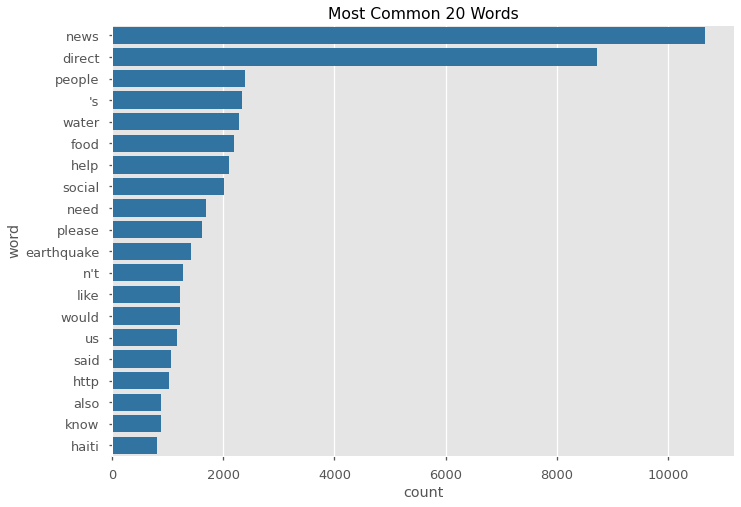

In [40]:
# Plot top 20 words.
all_words = [w for entry in dw.processed_train['all_text_tokenized'].values 
             for w in entry]

freqdist = FreqDist(all_words)
top = pd.DataFrame(freqdist.most_common(20), columns=['word', 'count'])
fig, ax = plt.subplots()
sns.barplot(x='count', y='word', data=top, orient='h', color=COLORS['blue'])
ax.set(title='Most Common 20 Words')
fig.tight_layout()

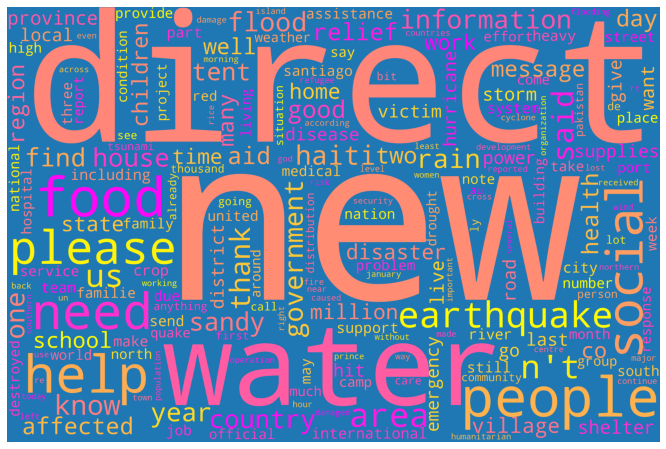

In [41]:
# Create wordcloud.
wordcloud = WordCloud(width=3000, 
                      height=2000, 
                      random_state=51, 
                      background_color=COLORS['blue'], 
                      colormap='spring', 
                      collocations=False).generate(' '.join(all_words))

dis.plot_wordcloud(wordcloud)

### What are the most common words for each label?

********************************************************************************
*                                   RELATED                                    *
********************************************************************************


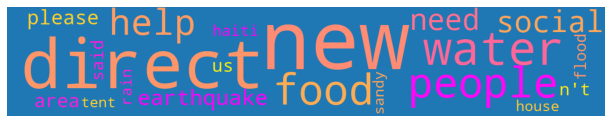

********************************************************************************
*                                   REQUEST                                    *
********************************************************************************


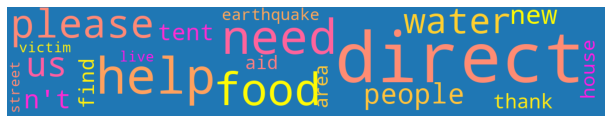

********************************************************************************
*                                 AID_RELATED                                  *
********************************************************************************


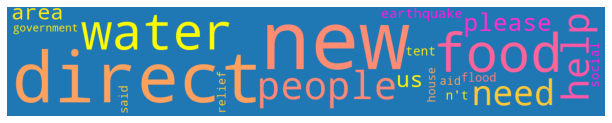

********************************************************************************
*                                 MEDICAL_HELP                                 *
********************************************************************************


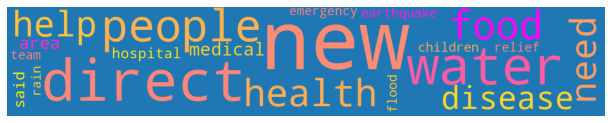

********************************************************************************
*                               MEDICAL_PRODUCTS                               *
********************************************************************************


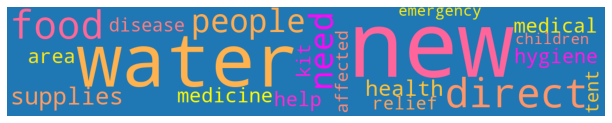

********************************************************************************
*                              SEARCH_AND_RESCUE                               *
********************************************************************************


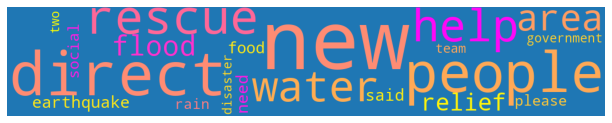

********************************************************************************
*                                   MILITARY                                   *
********************************************************************************


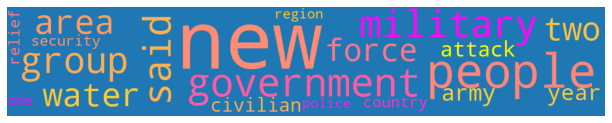

********************************************************************************
*                                    WATER                                     *
********************************************************************************


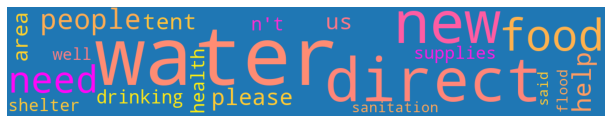

********************************************************************************
*                                     FOOD                                     *
********************************************************************************


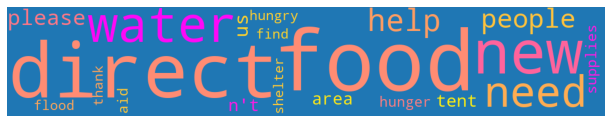

********************************************************************************
*                                   SHELTER                                    *
********************************************************************************


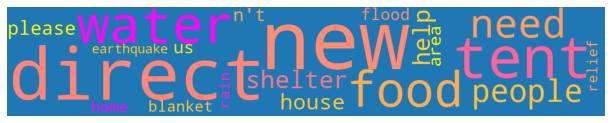

********************************************************************************
*                                   REFUGEES                                   *
********************************************************************************


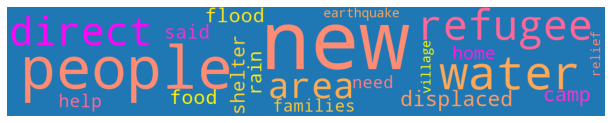

********************************************************************************
*                                    DEATH                                     *
********************************************************************************


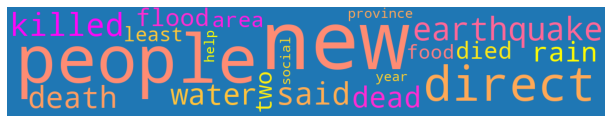

********************************************************************************
*                                  OTHER_AID                                   *
********************************************************************************


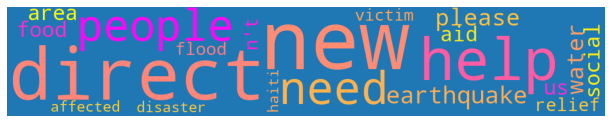

********************************************************************************
*                            INFRASTRUCTURE_RELATED                            *
********************************************************************************


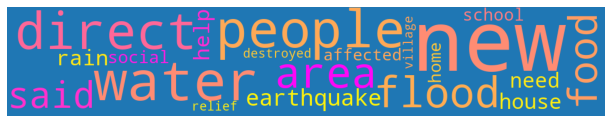

********************************************************************************
*                                  TRANSPORT                                   *
********************************************************************************


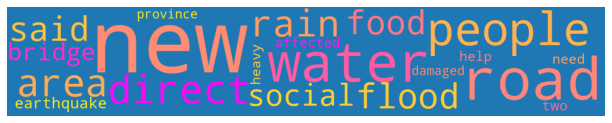

********************************************************************************
*                                  BUILDINGS                                   *
********************************************************************************


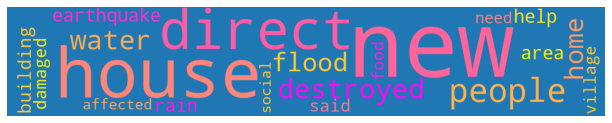

********************************************************************************
*                             OTHER_INFRASTRUCTURE                             *
********************************************************************************


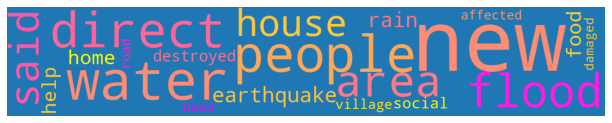

********************************************************************************
*                               WEATHER_RELATED                                *
********************************************************************************


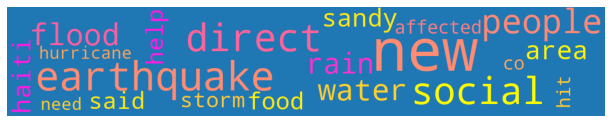

********************************************************************************
*                                    FLOODS                                    *
********************************************************************************


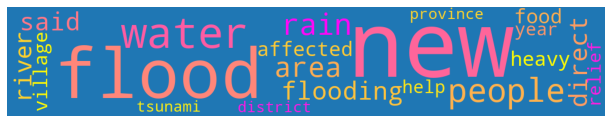

********************************************************************************
*                                    STORM                                     *
********************************************************************************


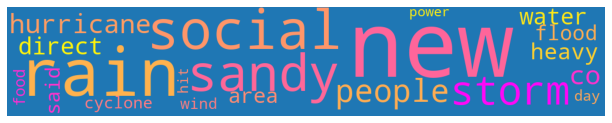

********************************************************************************
*                                  EARTHQUAKE                                  *
********************************************************************************


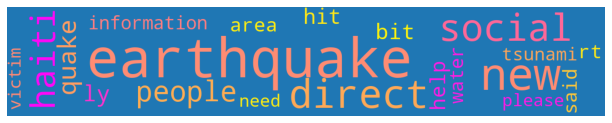

********************************************************************************
*                                OTHER_WEATHER                                 *
********************************************************************************


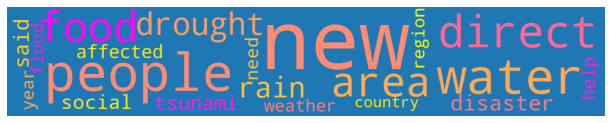

********************************************************************************
*                                DIRECT_REPORT                                 *
********************************************************************************


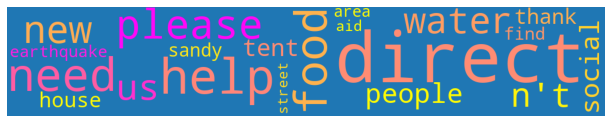

********************************************************************************
*                                   NO_LABEL                                   *
********************************************************************************


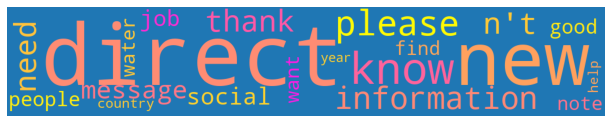

In [42]:
# Create dictionary for each column.
top_10_words = {}
for col in dw.target_columns:
    col_vocab = [
        word for entry in dw.processed_train[
            dw.processed_train[col] == 1]['all_text_tokenized'].values
        for word in entry if word not in sw
    ]
    top_10_words[col] = ' '.join(col_vocab)
    
# Show all wordclouds.
for col in top_10_words:
    wordcloud = WordCloud(width=1100, 
                          height=200, 
                          max_words=20,
                          random_state=51, 
                          background_color=COLORS['blue'], 
                          colormap='spring', 
                          collocations=False).generate(top_10_words[col])
    print(dis.headerize(col.upper()))
    dis.plot_wordcloud(wordcloud, figsize=(11,2))

### Phrases - Ngrams

********************************************************************************
*                             Most Common Phrases                              *
********************************************************************************


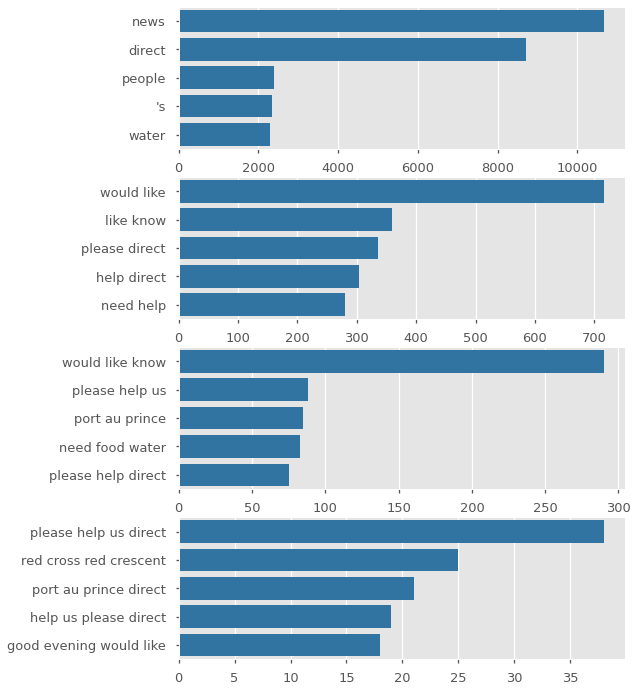

In [43]:
# Plot most common ngrams.
N = 4
print(dis.headerize('Most Common Phrases'))
fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 12))
for ax, i in zip(ax_lst.flatten(), range(1, N+1)):
    x = []
    y = []
    for t, count in dis.top_ngrams(dw.X_train(), i, top=5):
        x.append(count)
        y.append(' '.join(t))
    sns.barplot(x=x, y=y, orient='h', color=COLORS['blue'], ax=ax)

### Word Types - Spacy

In [44]:
spacey_load = spacy.load('en_core_web_sm')

In [45]:
# Example.
print(dis.headerize('Spacy Example'))

text = dw.processed_train['all_text'][0]
print(text)

# Read in text & render 'entitys'.
ex_spacy = spacey_load(text)
spacy.displacy.render(ex_spacy, style='ent')

********************************************************************************
*                                Spacy Example                                 *
********************************************************************************
Weather update - a cold front from Cuba that could pass over Haiti direct


In [46]:
# Work with a sample of the training data.
ents_lst = []
sample = dw.processed_train['all_text'][:10_000]
total = len(sample)

# Get total entities found.
for i, entry in enumerate(sample, 1):
    if i % 500 == 0:
        clear_output(wait=True)
        print(dis.headerize(f'Working: {i} / {total}'))
    spacey_doc = spacey_load(entry)
    ents_lst += [x.label_ for x in spacey_doc.ents]

********************************************************************************
*                            Working: 10000 / 10000                            *
********************************************************************************


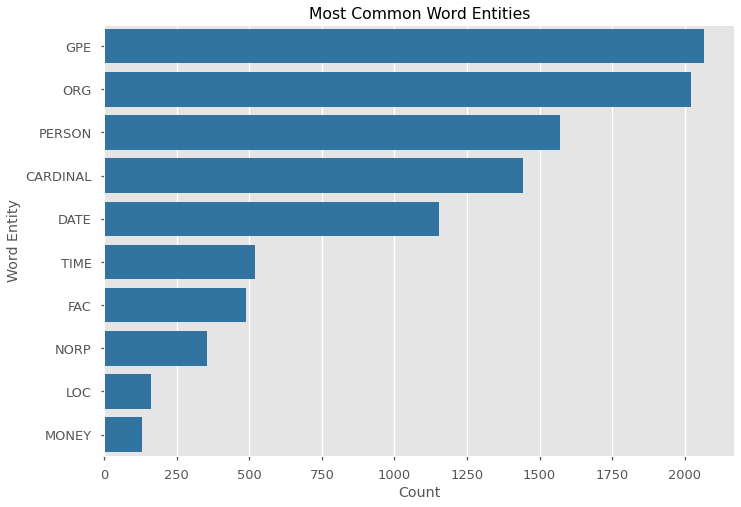

In [47]:
# Plot top entities from training sample.
top_10_ents = FreqDist(ents_lst).most_common(10)

x = []
y = []
for ent, count in top_10_ents:
    x.append(count)
    y.append(ent)

fig, ax = plt.subplots()
sns.barplot(x=x, y=y, color=COLORS['blue'], orient='h')
ax.set(title='Most Common Word Entities',
       xlabel='Count',
       ylabel='Word Entity')
fig.tight_layout()

## Modeling

### Baseline Model - Naive Bayes

#### `OneVsRestClassifier`

********************************************************************************
*                      OneVsRest Classifier - Naive Bayes                      *
********************************************************************************
F1 Score:        0.4768969465656235
Hamming Loss:    0.20349138489441637
Recall Score:    0.7024648333917669
Precision Score: 0.42799114402710453


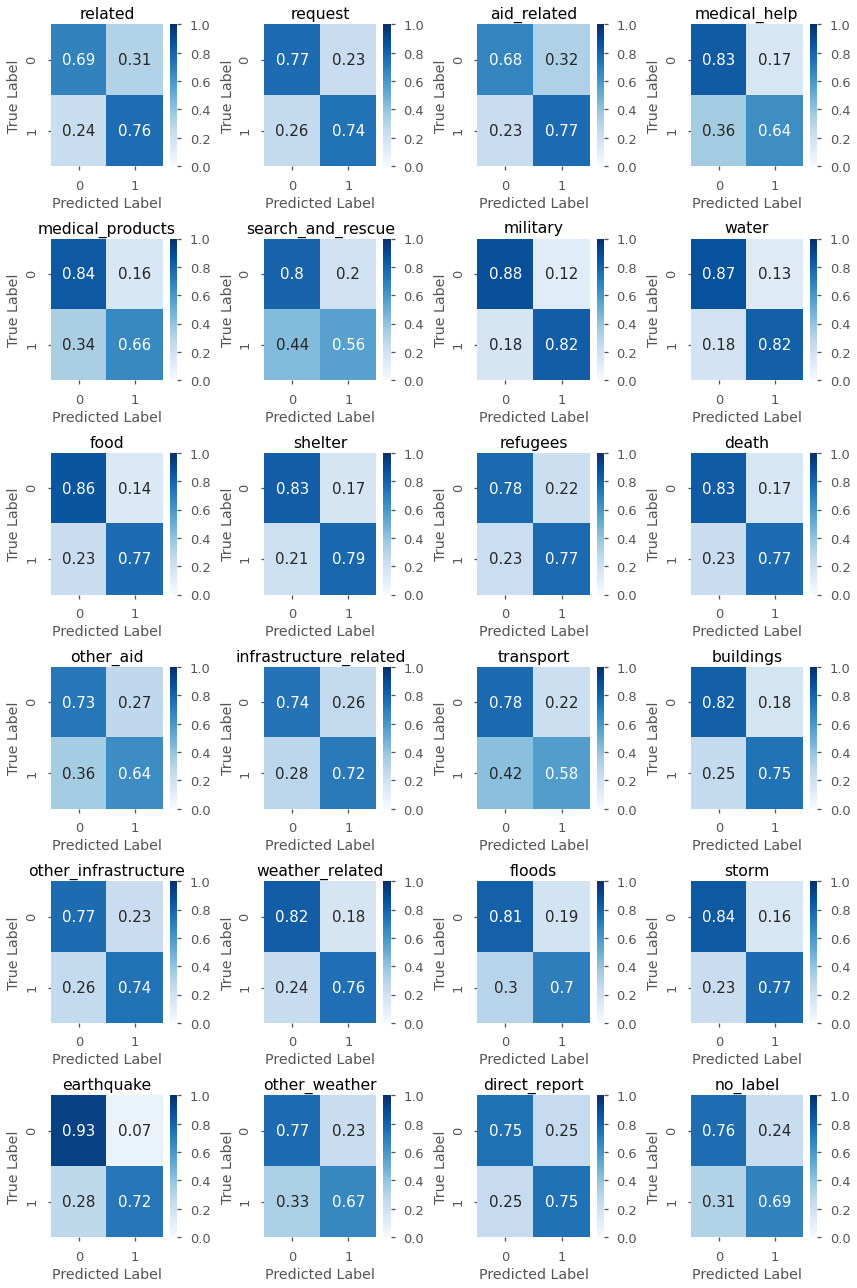

In [48]:
# Set up OvR Pipeline.
mean_embedder = dis.MeanEmbedder(glove)
ovr = OneVsRestClassifier(GaussianNB())

ovr_pipe = Pipeline([
    ('Mean_WordEmbedder', mean_embedder),
    ('OVR_Logistic_Regression', ovr)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='OneVsRest Classifier - Naive Bayes',
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

### SKLearn modeling:

#### GloVe Model

In [49]:
RUN_GRIDSEARCH = False

In [50]:
# GridSearch with Naive Bayes for random state suggestion.
# Not foolproof, but computationally cheap 
# compared to the other model types.
if RUN_GRIDSEARCH:
    mean_embedder = dis.MeanEmbedder(glove)
    nb_chain = ClassifierChain(GaussianNB(), order='random')

    nb_chain_pipe = Pipeline([
        ('Mean_WordEmbedder', mean_embedder),
        ('NB_Chain', nb_chain)
    ])
    
    # Iterate over first 300 random states of the ClassifierChain.
    chain_params = {
        'NB_Chain__random_state': range(300)
    }

    nb_grid = GridSearchCV(nb_chain_pipe,
                           chain_params,
                           cv=3)

    nb_grid.fit(dw.X_train(), dw.Y_train())
    
    BEST_R_STATE = nb_grid.best_params_['NB_Chain__random_state']
else:
    # From previous GridSearch.
    BEST_R_STATE = 162

#### `RandomForestClassifier`, `SupportVectorClassifier`, `Logistic Regression`

Using a `ClassifierChain`, each of these models will be fit for each target label (for a total of 24 models). In real time, they fit their next column's predictions on the previous trained model-chain in order to capture any potential dependence or interactions from one label to another. 

In [51]:
FIT_VANILLA_MODELS = False

In [52]:
if FIT_VANILLA_MODELS:
    # Fit vanilla rfc, svc, lr models through a ClassifierChain
    # with a preset random state for the ClassifierChain.
    mean_embedder = dis.MeanEmbedder(glove)
    classifiers = [
        ('Random Forest Classifier', RandomForestClassifier(n_estimators=100,
                                                            random_state=51)),
        ('Support Vector Classifier', SVC(gamma='auto', 
                                          random_state=51)),
        ('Logistic Regression', LogisticRegression(solver='liblinear', 
                                                   random_state=51))
    ]

    for name, clf in classifiers:
        # Build pipeline.
        pipe = Pipeline([
            ('Mean Word Embedder', mean_embedder),
            (name, ClassifierChain(clf, random_state=BEST_R_STATE))
        ],
        verbose=True)

        # Fit / predict.
        dis.fit_predict_model(clf=pipe,
                              X_train=dw.X_train(), 
                              Y_train=dw.Y_train(),
                              X_val=dw.X_val(),
                              Y_val=dw.Y_val(),
                              header=f'{name} - Classifier Chain',
                              return_pred=False,
                              plot_confusion=False)
        print('\n\n')

#### Printout
```
[Pipeline]  (step 1 of 2) Processing Mean Word Embedder, total=   0.6s
[Pipeline]  (step 2 of 2) Processing Random Forest Classifier, total= 6.4min
********************************************************************************
*                 Random Forest Classifier - Classifier Chain                  *
********************************************************************************
F1 Score:        0.606197791501203
Hamming Loss:    0.0853413654618474
Recall Score:    0.5847700753024134
Precision Score: 0.7612542335239576



[Pipeline]  (step 1 of 2) Processing Mean Word Embedder, total=   0.6s
[Pipeline]  (step 2 of 2) Processing Support Vector Classifier, total= 6.2min
********************************************************************************
*                 Support Vector Classifier - Classifier Chain                 *
********************************************************************************
F1 Score:        0.5994019567287872
Hamming Loss:    0.08848296411452261
Recall Score:    0.6022608318932133
Precision Score: 0.7154660115114837



[Pipeline]  (step 1 of 2) Processing Mean Word Embedder, total=   0.5s
[Pipeline]  (step 2 of 2) Processing Logistic Regression, total=  15.5s
********************************************************************************
*                    Logistic Regression - Classifier Chain                    *
********************************************************************************
F1 Score:        0.6164320750530966
Hamming Loss:    0.08770566135509782
Recall Score:    0.6355876323824017
Precision Score: 0.7142749184140555
```

#### Vectorized Words Modeling

In [53]:
# Vectorize data.
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(dw.X_train('all_text'))
X_val_vec = vectorizer.transform(dw.X_val('all_text'))

print(f'Data Shape:\t{X_train_vec.shape}')
print(f'Vocab Size:\t{len(vectorizer.vocabulary_)}')

Data Shape:	(21046, 31233)
Vocab Size:	31233


In [54]:
FIT_RFC = False

In [55]:
if FIT_RFC:
    # Fit Random Forest on vectorized data.
    rfc = RandomForestClassifier(n_estimators=100)
    dis.fit_predict_model(clf=rfc,
                          X_train=X_train_vec, 
                          Y_train=dw.Y_train(),
                          X_val=X_val_vec,
                          Y_val=dw.Y_val(),
                          header=f'Vectorized Data - RFC',
                          return_pred=False,
                          plot_confusion=False)
    
    ## Plot Feature Importance
    importance = pd.Series(rfc.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    fig, ax = plt.subplots()
    importance.sort_values().tail(30).plot(kind='barh', ax=ax)
    ax.set(title='RFC Most Important Words',
           ylabel='Word')
    fig.tight_layout()

```
********************************************************************************
*                            Vectorized Data - RFC                             *
********************************************************************************

F1 Score:        0.5609183393894882
Hamming Loss:    0.08916310402901931
Recall Score:    0.5087418305411721
Precision Score: 0.7752105194973442
```

<img src='./images/rfc_feature_importance.png'>

### Train Recurrent Neural Network (*RNN*).

#### Processing - Tokenize Data

In [56]:
# Number of unique words.
freq_dist = FreqDist([word.lower() 
                      for entry in dw.X_train() 
                      for word in entry])

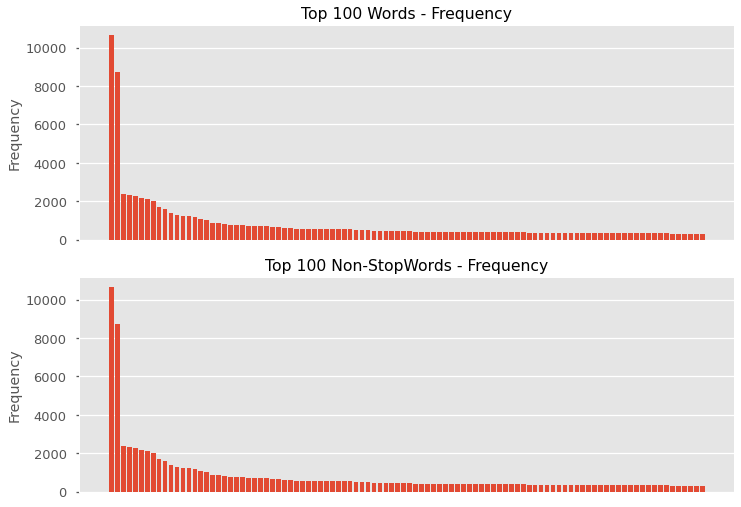

In [57]:
# Plot frequencies for most common 100 words.
top_100 = [x[1] for x in freq_dist.most_common(100)]
top_100_no_sw = [x[1] for x in freq_dist.most_common() 
                 if x[0] not in sw][:100]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.bar(range(100), top_100)
ax2.bar(range(100), top_100_no_sw)

ax1.set(title='Top 100 Words - Frequency',
       ylabel='Frequency')
ax1.set_xticks([])
ax2.set(title='Top 100 Non-StopWords - Frequency',
       ylabel='Frequency')
ax2.set_xticks([])

fig.tight_layout()

In [58]:
# Create padded tokens of 'all_text' from DataWarehouse.
all_text_lst = [dw.X_train(), dw.X_val(), dw.X_test()]

tokenizer, (X_train_tok, X_val_tok, X_test_tok) = dis.tokenize_series(
    dw.X_train(),
    all_text_lst)

********************************************************************************
*                           Tokenizer Created & Fit                            *
********************************************************************************
Ex:


[['weather',
  'update',
  'cold',
  'front',
  'cuba',
  'could',
  'pass',
  'haiti',
  'direct'],
 ['hurricane', 'direct']]

********************************************************************************
*                              Series' Tokenized                               *
********************************************************************************
Ex:


[[113, 1819, 333, 847, 2513, 62, 445, 20, 2], [68, 2]]

********************************************************************************
*                                  Tokenized                                   *
********************************************************************************
Ex:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  113, 1819,  333,  847, 2513,   62,  445,   20,
           2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

********************************************************************************
*                                   Finished                                   *
********************************************************************************


In [59]:
# Set num_words & embedding size for models.
num_words = len(tokenizer.word_index) + 1
embedding_size = 128

#### LSTM

In [60]:
TRAIN_LSTM = False

In [61]:
lstm_model = dis.build_model(num_words, embedding_size, lstm=True)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         4534400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                12850     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1

In [62]:
lstm_checkpoint_path = "models/model_callbacks/lstm/cp.ckpt"
lstm_checkpoint_dir = os.path.dirname(lstm_checkpoint_path)

if TRAIN_LSTM:
    # Create a callback that saves the model's weights
    lstm_callback = ModelCheckpoint(filepath=lstm_checkpoint_path,
                                    save_weights_only=True,
                                    verbose=1)

    lstm_model_history = lstm_model.fit(X_train_tok, 
                                        dw.Y_train(), 
                                        epochs=10, 
                                        batch_size=32, 
                                        validation_data=(X_val_tok, 
                                                         dw.Y_val()),
                                        callbacks=[lstm_callback])
    dis.plot_history(lstm_model_history,
                     [x for x in lstm_model_history.history.keys()
                      if not x.startswith('val')])
    
elif os.listdir(lstm_checkpoint_dir):
    # Load in pretrained weights.
    lstm_model.load_weights(lstm_checkpoint_path)

<img src='./images/lstm.png'>

In [63]:
# Find optimal prediction threshold.
y_val_pred = lstm_model.predict(X_val_tok)

dis.fit_thresholds(dw.Y_val(), y_val_pred, 'f1_score')

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.6089164055893845             *
********************************************************************************
********************************************************************************
*                                   F1_SCORE                                   *
********************************************************************************
F1 Score:        0.6089164055893845
Hamming Loss:    0.08747894805026558
Recall Score:    0.6315011942935401
Precision Score: 0.6876132094359844


#### GRU

In [64]:
TRAIN_GRU = False

In [65]:
gru_model = dis.build_model(num_words, embedding_size, gru=True)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         4534400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         198144    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)               

In [66]:
gru_checkpoint_path = "models/model_callbacks/gru/cp.ckpt"
gru_checkpoint_dir = os.path.dirname(gru_checkpoint_path)

if TRAIN_GRU:
    # Create a callback that saves the model's weights
    gru_callback = ModelCheckpoint(filepath=gru_checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

    gru_model_history = gru_model.fit(X_train_tok, 
                                      dw.Y_train(), 
                                      epochs=10, 
                                      batch_size=32, 
                                      validation_data=(X_val_tok, 
                                                       dw.Y_val()),
                                      callbacks=[gru_callback])
    dis.plot_history(gru_model_history,
                     [x for x in gru_model_history.history.keys()
                      if not x.startswith('val')])
elif os.listdir(gru_checkpoint_dir):
    # Load in pretrained weights.
    gru_model.load_weights(gru_checkpoint_path)

<img src='./images/gru.png'>

In [67]:
# Find optimal prediction threshold.
y_val_pred = gru_model.predict(X_val_tok)

dis.fit_thresholds(dw.Y_val(), y_val_pred, 'f1_score')

********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.6093223734885632             *
********************************************************************************
********************************************************************************
*                                   F1_SCORE                                   *
********************************************************************************
F1 Score:        0.6093223734885632
Hamming Loss:    0.08948698017877964
Recall Score:    0.6400201749382153
Precision Score: 0.6747946541086844


### Testing

In [68]:
# # Test models.
# model = models.Sequential()

# model.add(layers.Embedding(num_words, embedding_size))
# model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
# model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True)))
# model.add(layers.GlobalMaxPool1D())
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(50, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(24, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.Adam(learning_rate=.001),
#               metrics=[tf.keras.metrics.Recall()])

Epoch 1/10


186/658 [=======>......................] - ETA: 0s - loss: 0.6900 - recall_2: 0.47 - ETA: 35s - loss: 0.6879 - recall_2: 0.451 - ETA: 41s - loss: 0.6863 - recall_2: 0.413 - ETA: 43s - loss: 0.6831 - recall_2: 0.405 - ETA: 45s - loss: 0.6809 - recall_2: 0.398 - ETA: 46s - loss: 0.6775 - recall_2: 0.402 - ETA: 47s - loss: 0.6748 - recall_2: 0.390 - ETA: 48s - loss: 0.6706 - recall_2: 0.393 - ETA: 48s - loss: 0.6677 - recall_2: 0.382 - ETA: 49s - loss: 0.6632 - recall_2: 0.378 - ETA: 50s - loss: 0.6581 - recall_2: 0.375 - ETA: 50s - loss: 0.6529 - recall_2: 0.367 - ETA: 51s - loss: 0.6463 - recall_2: 0.364 - ETA: 52s - loss: 0.6406 - recall_2: 0.366 - ETA: 52s - loss: 0.6338 - recall_2: 0.366 - ETA: 53s - loss: 0.6283 - recall_2: 0.362 - ETA: 53s - loss: 0.6225 - recall_2: 0.361 - ETA: 53s - loss: 0.6150 - recall_2: 0.359 - ETA: 53s - loss: 0.6085 - recall_2: 0.357 - ETA: 54s - loss: 0.6010 - recall_2: 0.356 - ETA: 54s - loss: 0.5958 - recall_2: 0.352 - ETA: 54s - loss: 0.5863 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.3271 - recall_2: 0.352 - ETA: 26s - loss: 0.3268 - recall_2: 0.352 - ETA: 26s - loss: 0.3267 - recall_2: 0.352 - ETA: 26s - loss: 0.3266 - recall_2: 0.353 - ETA: 26s - loss: 0.3266 - recall_2: 0.353 - ETA: 26s - loss: 0.3264 - recall_2: 0.353 - ETA: 26s - loss: 0.3262 - recall_2: 0.354 - ETA: 26s - loss: 0.3259 - recall_2: 0.354 - ETA: 26s - loss: 0.3257 - recall_2: 0.355 - ETA: 26s - loss: 0.3254 - recall_2: 0.355 - ETA: 26s - loss: 0.3252 - recall_2: 0.355 - ETA: 25s - loss: 0.3251 - recall_2: 0.355 - ETA: 25s - loss: 0.3249 - recall_2: 0.355 - ETA: 25s - loss: 0.3248 - recall_2: 0.356 - ETA: 25s - loss: 0.3247 - recall_2: 0.356 - ETA: 25s - loss: 0.3244 - recall_2: 0.356 - ETA: 25s - loss: 0.3243 - recall_2: 0.356 - ETA: 25s - loss: 0.3241 - recall_2: 0.356 - ETA: 25s - loss: 0.3240 - recall_2: 0.356 - ETA: 25s - loss: 0.3236 - recall_2: 0.357 - ETA: 25s - loss: 0.3236 - recall_2: 0.357 - ETA: 25s - loss: 0.3234 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.3061 - recall_2: 0.38 - ETA: 9s - loss: 0.3060 - recall_2: 0.38 - ETA: 9s - loss: 0.3060 - recall_2: 0.38 - ETA: 9s - loss: 0.3057 - recall_2: 0.38 - ETA: 8s - loss: 0.3056 - recall_2: 0.38 - ETA: 8s - loss: 0.3055 - recall_2: 0.38 - ETA: 8s - loss: 0.3055 - recall_2: 0.38 - ETA: 8s - loss: 0.3054 - recall_2: 0.38 - ETA: 8s - loss: 0.3053 - recall_2: 0.38 - ETA: 8s - loss: 0.3053 - recall_2: 0.38 - ETA: 8s - loss: 0.3053 - recall_2: 0.38 - ETA: 8s - loss: 0.3052 - recall_2: 0.38 - ETA: 8s - loss: 0.3050 - recall_2: 0.38 - ETA: 8s - loss: 0.3050 - recall_2: 0.38 - ETA: 8s - loss: 0.3049 - recall_2: 0.38 - ETA: 7s - loss: 0.3048 - recall_2: 0.38 - ETA: 7s - loss: 0.3047 - recall_2: 0.38 - ETA: 7s - loss: 0.3044 - recall_2: 0.38 - ETA: 7s - loss: 0.3043 - recall_2: 0.38 - ETA: 7s - loss: 0.3043 - recall_2: 0.38 - ETA: 7s - loss: 0.3043 - recall_2: 0.38 - ETA: 7s - loss: 0.3043 - recall_2: 0.38 - ETA: 7s - loss: 0.3041 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.2546 - recall_2: 0.50 - ETA: 30s - loss: 0.2526 - recall_2: 0.463 - ETA: 40s - loss: 0.2337 - recall_2: 0.461 - ETA: 45s - loss: 0.2270 - recall_2: 0.478 - ETA: 48s - loss: 0.2292 - recall_2: 0.477 - ETA: 50s - loss: 0.2311 - recall_2: 0.478 - ETA: 51s - loss: 0.2397 - recall_2: 0.463 - ETA: 52s - loss: 0.2382 - recall_2: 0.467 - ETA: 53s - loss: 0.2392 - recall_2: 0.463 - ETA: 54s - loss: 0.2381 - recall_2: 0.463 - ETA: 54s - loss: 0.2368 - recall_2: 0.469 - ETA: 55s - loss: 0.2398 - recall_2: 0.470 - ETA: 55s - loss: 0.2375 - recall_2: 0.474 - ETA: 55s - loss: 0.2345 - recall_2: 0.477 - ETA: 55s - loss: 0.2354 - recall_2: 0.482 - ETA: 55s - loss: 0.2341 - recall_2: 0.484 - ETA: 55s - loss: 0.2342 - recall_2: 0.486 - ETA: 56s - loss: 0.2363 - recall_2: 0.481 - ETA: 56s - loss: 0.2360 - recall_2: 0.482 - ETA: 56s - loss: 0.2376 - recall_2: 0.479 - ETA: 56s - loss: 0.2365 - recall_2: 0.481 - ETA: 56s - loss: 0.2348 - recall_2:

558/658 [========================>.....] - ETA: 26s - loss: 0.2312 - recall_2: 0.509 - ETA: 26s - loss: 0.2313 - recall_2: 0.509 - ETA: 26s - loss: 0.2311 - recall_2: 0.509 - ETA: 26s - loss: 0.2310 - recall_2: 0.509 - ETA: 26s - loss: 0.2310 - recall_2: 0.510 - ETA: 26s - loss: 0.2309 - recall_2: 0.510 - ETA: 25s - loss: 0.2310 - recall_2: 0.510 - ETA: 25s - loss: 0.2309 - recall_2: 0.510 - ETA: 25s - loss: 0.2308 - recall_2: 0.510 - ETA: 25s - loss: 0.2310 - recall_2: 0.510 - ETA: 25s - loss: 0.2310 - recall_2: 0.510 - ETA: 25s - loss: 0.2309 - recall_2: 0.510 - ETA: 25s - loss: 0.2309 - recall_2: 0.510 - ETA: 25s - loss: 0.2309 - recall_2: 0.510 - ETA: 25s - loss: 0.2308 - recall_2: 0.510 - ETA: 25s - loss: 0.2308 - recall_2: 0.510 - ETA: 24s - loss: 0.2308 - recall_2: 0.509 - ETA: 24s - loss: 0.2307 - recall_2: 0.509 - ETA: 24s - loss: 0.2306 - recall_2: 0.509 - ETA: 24s - loss: 0.2306 - recall_2: 0.509 - ETA: 24s - loss: 0.2308 - recall_2: 0.509 - ETA: 24s - loss: 0.2307 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.2296 - recall_2: 0.51 - ETA: 9s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2297 - recall_2: 0.51 - ETA: 8s - loss: 0.2297 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2297 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 8s - loss: 0.2296 - recall_2: 0.51 - ETA: 7s - loss: 0.2296 - recall_2: 0.51 - ETA: 7s - loss: 0.2296 - recall_2: 0.51 - ETA: 7s - loss: 0.2296 - recall_2: 0.51 - ETA: 7s - loss: 0.2296 - recall_2: 0.51 - ETA: 7s - loss: 0.2295 - recall_2: 0.51 - ETA: 7s - loss: 0.2295 - recall_2: 0.51 - ETA: 7s - loss: 0.2294 - recall_2: 0.51 - ETA: 7s - loss: 0.2294 - recall_2: 0.51 - ETA: 7s - loss: 0.2294 - recall_2: 0.51 - ETA: 7s - loss: 0.2293 - recall_2

186/658 [=======>......................] - ETA: 1s - loss: 0.2413 - recall_2: 0.55 - ETA: 30s - loss: 0.2242 - recall_2: 0.547 - ETA: 40s - loss: 0.2146 - recall_2: 0.553 - ETA: 45s - loss: 0.2061 - recall_2: 0.550 - ETA: 49s - loss: 0.2147 - recall_2: 0.542 - ETA: 50s - loss: 0.2114 - recall_2: 0.551 - ETA: 52s - loss: 0.2094 - recall_2: 0.552 - ETA: 53s - loss: 0.2111 - recall_2: 0.550 - ETA: 54s - loss: 0.2165 - recall_2: 0.542 - ETA: 54s - loss: 0.2106 - recall_2: 0.559 - ETA: 55s - loss: 0.2091 - recall_2: 0.563 - ETA: 55s - loss: 0.2126 - recall_2: 0.557 - ETA: 55s - loss: 0.2089 - recall_2: 0.564 - ETA: 55s - loss: 0.2102 - recall_2: 0.563 - ETA: 55s - loss: 0.2081 - recall_2: 0.565 - ETA: 55s - loss: 0.2076 - recall_2: 0.562 - ETA: 55s - loss: 0.2104 - recall_2: 0.559 - ETA: 56s - loss: 0.2088 - recall_2: 0.559 - ETA: 56s - loss: 0.2115 - recall_2: 0.558 - ETA: 56s - loss: 0.2131 - recall_2: 0.557 - ETA: 56s - loss: 0.2131 - recall_2: 0.556 - ETA: 56s - loss: 0.2117 - recall_2:

558/658 [========================>.....] - ETA: 26s - loss: 0.1978 - recall_2: 0.574 - ETA: 26s - loss: 0.1977 - recall_2: 0.574 - ETA: 26s - loss: 0.1976 - recall_2: 0.574 - ETA: 26s - loss: 0.1977 - recall_2: 0.574 - ETA: 26s - loss: 0.1977 - recall_2: 0.574 - ETA: 26s - loss: 0.1978 - recall_2: 0.573 - ETA: 25s - loss: 0.1978 - recall_2: 0.573 - ETA: 25s - loss: 0.1978 - recall_2: 0.573 - ETA: 25s - loss: 0.1978 - recall_2: 0.573 - ETA: 25s - loss: 0.1978 - recall_2: 0.573 - ETA: 25s - loss: 0.1979 - recall_2: 0.573 - ETA: 25s - loss: 0.1979 - recall_2: 0.573 - ETA: 25s - loss: 0.1979 - recall_2: 0.573 - ETA: 25s - loss: 0.1979 - recall_2: 0.574 - ETA: 25s - loss: 0.1979 - recall_2: 0.574 - ETA: 25s - loss: 0.1978 - recall_2: 0.574 - ETA: 25s - loss: 0.1978 - recall_2: 0.574 - ETA: 24s - loss: 0.1978 - recall_2: 0.574 - ETA: 24s - loss: 0.1978 - recall_2: 0.574 - ETA: 24s - loss: 0.1979 - recall_2: 0.574 - ETA: 24s - loss: 0.1980 - recall_2: 0.573 - ETA: 24s - loss: 0.1980 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1981 - recall_2: 0.57 - ETA: 9s - loss: 0.1982 - recall_2: 0.57 - ETA: 9s - loss: 0.1983 - recall_2: 0.57 - ETA: 8s - loss: 0.1983 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 8s - loss: 0.1983 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 8s - loss: 0.1983 - recall_2: 0.57 - ETA: 8s - loss: 0.1983 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 8s - loss: 0.1981 - recall_2: 0.57 - ETA: 8s - loss: 0.1982 - recall_2: 0.57 - ETA: 7s - loss: 0.1982 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1983 - recall_2: 0.57 - ETA: 7s - loss: 0.1984 - recall_2: 0.57 - ETA: 7s - loss: 0.1984 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.2057 - recall_2: 0.64 - ETA: 30s - loss: 0.1970 - recall_2: 0.597 - ETA: 39s - loss: 0.2059 - recall_2: 0.585 - ETA: 44s - loss: 0.2083 - recall_2: 0.570 - ETA: 47s - loss: 0.2059 - recall_2: 0.571 - ETA: 49s - loss: 0.2038 - recall_2: 0.572 - ETA: 51s - loss: 0.1960 - recall_2: 0.574 - ETA: 52s - loss: 0.1975 - recall_2: 0.570 - ETA: 53s - loss: 0.1965 - recall_2: 0.569 - ETA: 53s - loss: 0.1973 - recall_2: 0.566 - ETA: 54s - loss: 0.1970 - recall_2: 0.563 - ETA: 55s - loss: 0.1957 - recall_2: 0.566 - ETA: 55s - loss: 0.1931 - recall_2: 0.568 - ETA: 55s - loss: 0.1925 - recall_2: 0.567 - ETA: 55s - loss: 0.1915 - recall_2: 0.567 - ETA: 55s - loss: 0.1900 - recall_2: 0.571 - ETA: 55s - loss: 0.1872 - recall_2: 0.574 - ETA: 55s - loss: 0.1857 - recall_2: 0.578 - ETA: 55s - loss: 0.1859 - recall_2: 0.575 - ETA: 55s - loss: 0.1858 - recall_2: 0.576 - ETA: 55s - loss: 0.1864 - recall_2: 0.578 - ETA: 55s - loss: 0.1852 - recall_2:

558/658 [========================>.....] - ETA: 26s - loss: 0.1758 - recall_2: 0.614 - ETA: 26s - loss: 0.1757 - recall_2: 0.615 - ETA: 26s - loss: 0.1760 - recall_2: 0.614 - ETA: 26s - loss: 0.1760 - recall_2: 0.614 - ETA: 26s - loss: 0.1759 - recall_2: 0.615 - ETA: 26s - loss: 0.1758 - recall_2: 0.615 - ETA: 26s - loss: 0.1756 - recall_2: 0.615 - ETA: 25s - loss: 0.1755 - recall_2: 0.615 - ETA: 25s - loss: 0.1755 - recall_2: 0.615 - ETA: 25s - loss: 0.1757 - recall_2: 0.615 - ETA: 25s - loss: 0.1756 - recall_2: 0.615 - ETA: 25s - loss: 0.1757 - recall_2: 0.615 - ETA: 25s - loss: 0.1758 - recall_2: 0.615 - ETA: 25s - loss: 0.1757 - recall_2: 0.615 - ETA: 25s - loss: 0.1756 - recall_2: 0.615 - ETA: 25s - loss: 0.1755 - recall_2: 0.615 - ETA: 25s - loss: 0.1754 - recall_2: 0.615 - ETA: 25s - loss: 0.1754 - recall_2: 0.615 - ETA: 24s - loss: 0.1754 - recall_2: 0.615 - ETA: 24s - loss: 0.1755 - recall_2: 0.615 - ETA: 24s - loss: 0.1756 - recall_2: 0.615 - ETA: 24s - loss: 0.1755 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1762 - recall_2: 0.61 - ETA: 9s - loss: 0.1763 - recall_2: 0.61 - ETA: 9s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1762 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1762 - recall_2: 0.61 - ETA: 8s - loss: 0.1762 - recall_2: 0.61 - ETA: 8s - loss: 0.1762 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1762 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 8s - loss: 0.1763 - recall_2: 0.61 - ETA: 7s - loss: 0.1762 - recall_2: 0.61 - ETA: 7s - loss: 0.1762 - recall_2: 0.61 - ETA: 7s - loss: 0.1761 - recall_2: 0.61 - ETA: 7s - loss: 0.1761 - recall_2: 0.61 - ETA: 7s - loss: 0.1760 - recall_2: 0.61 - ETA: 7s - loss: 0.1761 - recall_2: 0.61 - ETA: 7s - loss: 0.1761 - recall_2: 0.61 - ETA: 7s - loss: 0.1763 - recall_2: 0.61 - ETA: 7s - loss: 0.1762 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.1843 - recall_2: 0.61 - ETA: 30s - loss: 0.1563 - recall_2: 0.654 - ETA: 40s - loss: 0.1686 - recall_2: 0.625 - ETA: 46s - loss: 0.1652 - recall_2: 0.644 - ETA: 49s - loss: 0.1668 - recall_2: 0.648 - ETA: 51s - loss: 0.1683 - recall_2: 0.658 - ETA: 52s - loss: 0.1650 - recall_2: 0.660 - ETA: 53s - loss: 0.1625 - recall_2: 0.664 - ETA: 54s - loss: 0.1624 - recall_2: 0.660 - ETA: 54s - loss: 0.1581 - recall_2: 0.667 - ETA: 54s - loss: 0.1599 - recall_2: 0.664 - ETA: 55s - loss: 0.1573 - recall_2: 0.664 - ETA: 55s - loss: 0.1602 - recall_2: 0.660 - ETA: 55s - loss: 0.1582 - recall_2: 0.663 - ETA: 56s - loss: 0.1606 - recall_2: 0.656 - ETA: 56s - loss: 0.1620 - recall_2: 0.652 - ETA: 56s - loss: 0.1621 - recall_2: 0.654 - ETA: 56s - loss: 0.1600 - recall_2: 0.655 - ETA: 56s - loss: 0.1622 - recall_2: 0.650 - ETA: 56s - loss: 0.1620 - recall_2: 0.649 - ETA: 56s - loss: 0.1618 - recall_2: 0.647 - ETA: 56s - loss: 0.1608 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.1595 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.645 - ETA: 26s - loss: 0.1595 - recall_2: 0.646 - ETA: 26s - loss: 0.1595 - recall_2: 0.646 - ETA: 26s - loss: 0.1594 - recall_2: 0.646 - ETA: 26s - loss: 0.1595 - recall_2: 0.645 - ETA: 26s - loss: 0.1596 - recall_2: 0.646 - ETA: 25s - loss: 0.1595 - recall_2: 0.646 - ETA: 25s - loss: 0.1594 - recall_2: 0.646 - ETA: 25s - loss: 0.1594 - recall_2: 0.646 - ETA: 25s - loss: 0.1594 - recall_2: 0.646 - ETA: 25s - loss: 0.1593 - recall_2: 0.646 - ETA: 25s - loss: 0.1593 - recall_2: 0.646 - ETA: 25s - loss: 0.1594 - recall_2: 0.646 - ETA: 25s - loss: 0.1594 - recall_2: 0.646 - ETA: 25s - loss: 0.1593 - recall_2: 0.646 - ETA: 25s - loss: 0.1593 - recall_2: 0.646 - ETA: 24s - loss: 0.1595 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1587 - recall_2: 0.64 - ETA: 9s - loss: 0.1588 - recall_2: 0.64 - ETA: 9s - loss: 0.1588 - recall_2: 0.64 - ETA: 9s - loss: 0.1587 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1587 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1587 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1586 - recall_2: 0.64 - ETA: 8s - loss: 0.1587 - recall_2: 0.64 - ETA: 7s - loss: 0.1587 - recall_2: 0.64 - ETA: 7s - loss: 0.1587 - recall_2: 0.64 - ETA: 7s - loss: 0.1587 - recall_2: 0.64 - ETA: 7s - loss: 0.1587 - recall_2: 0.64 - ETA: 7s - loss: 0.1586 - recall_2: 0.64 - ETA: 7s - loss: 0.1586 - recall_2: 0.64 - ETA: 7s - loss: 0.1586 - recall_2: 0.64 - ETA: 7s - loss: 0.1586 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.2027 - recall_2: 0.60 - ETA: 31s - loss: 0.1760 - recall_2: 0.623 - ETA: 41s - loss: 0.1582 - recall_2: 0.648 - ETA: 46s - loss: 0.1541 - recall_2: 0.636 - ETA: 49s - loss: 0.1535 - recall_2: 0.639 - ETA: 50s - loss: 0.1496 - recall_2: 0.641 - ETA: 51s - loss: 0.1429 - recall_2: 0.658 - ETA: 52s - loss: 0.1425 - recall_2: 0.656 - ETA: 53s - loss: 0.1387 - recall_2: 0.661 - ETA: 54s - loss: 0.1382 - recall_2: 0.669 - ETA: 55s - loss: 0.1403 - recall_2: 0.670 - ETA: 55s - loss: 0.1406 - recall_2: 0.673 - ETA: 55s - loss: 0.1451 - recall_2: 0.670 - ETA: 55s - loss: 0.1478 - recall_2: 0.667 - ETA: 56s - loss: 0.1475 - recall_2: 0.667 - ETA: 56s - loss: 0.1429 - recall_2: 0.673 - ETA: 56s - loss: 0.1424 - recall_2: 0.671 - ETA: 56s - loss: 0.1451 - recall_2: 0.663 - ETA: 56s - loss: 0.1459 - recall_2: 0.665 - ETA: 56s - loss: 0.1456 - recall_2: 0.664 - ETA: 56s - loss: 0.1450 - recall_2: 0.668 - ETA: 56s - loss: 0.1460 - recall_2:

558/658 [========================>.....] - ETA: 26s - loss: 0.1462 - recall_2: 0.678 - ETA: 26s - loss: 0.1461 - recall_2: 0.678 - ETA: 26s - loss: 0.1461 - recall_2: 0.678 - ETA: 26s - loss: 0.1462 - recall_2: 0.678 - ETA: 26s - loss: 0.1462 - recall_2: 0.678 - ETA: 26s - loss: 0.1462 - recall_2: 0.678 - ETA: 26s - loss: 0.1462 - recall_2: 0.678 - ETA: 26s - loss: 0.1463 - recall_2: 0.678 - ETA: 26s - loss: 0.1463 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1463 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1461 - recall_2: 0.678 - ETA: 25s - loss: 0.1462 - recall_2: 0.678 - ETA: 25s - loss: 0.1461 - recall_2: 0.678 - ETA: 24s - loss: 0.1462 - recall_2: 0.678 - ETA: 24s - loss: 0.1461 - recall_2: 0.678 - ETA: 24s - loss: 0.1461 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1460 - recall_2: 0.67 - ETA: 9s - loss: 0.1459 - recall_2: 0.67 - ETA: 9s - loss: 0.1460 - recall_2: 0.67 - ETA: 9s - loss: 0.1460 - recall_2: 0.67 - ETA: 8s - loss: 0.1459 - recall_2: 0.67 - ETA: 8s - loss: 0.1459 - recall_2: 0.67 - ETA: 8s - loss: 0.1459 - recall_2: 0.67 - ETA: 8s - loss: 0.1458 - recall_2: 0.67 - ETA: 8s - loss: 0.1458 - recall_2: 0.67 - ETA: 8s - loss: 0.1457 - recall_2: 0.67 - ETA: 8s - loss: 0.1457 - recall_2: 0.67 - ETA: 8s - loss: 0.1456 - recall_2: 0.67 - ETA: 8s - loss: 0.1456 - recall_2: 0.67 - ETA: 8s - loss: 0.1456 - recall_2: 0.67 - ETA: 8s - loss: 0.1457 - recall_2: 0.67 - ETA: 7s - loss: 0.1456 - recall_2: 0.67 - ETA: 7s - loss: 0.1456 - recall_2: 0.67 - ETA: 7s - loss: 0.1456 - recall_2: 0.67 - ETA: 7s - loss: 0.1456 - recall_2: 0.67 - ETA: 7s - loss: 0.1457 - recall_2: 0.67 - ETA: 7s - loss: 0.1457 - recall_2: 0.67 - ETA: 7s - loss: 0.1457 - recall_2: 0.67 - ETA: 7s - loss: 0.1456 - recall_2

186/658 [=======>......................] - ETA: 1s - loss: 0.0878 - recall_2: 0.73 - ETA: 29s - loss: 0.1198 - recall_2: 0.705 - ETA: 39s - loss: 0.1068 - recall_2: 0.712 - ETA: 45s - loss: 0.1128 - recall_2: 0.717 - ETA: 48s - loss: 0.1176 - recall_2: 0.716 - ETA: 50s - loss: 0.1157 - recall_2: 0.723 - ETA: 51s - loss: 0.1141 - recall_2: 0.725 - ETA: 52s - loss: 0.1168 - recall_2: 0.724 - ETA: 53s - loss: 0.1198 - recall_2: 0.716 - ETA: 53s - loss: 0.1226 - recall_2: 0.713 - ETA: 54s - loss: 0.1231 - recall_2: 0.713 - ETA: 54s - loss: 0.1243 - recall_2: 0.709 - ETA: 55s - loss: 0.1236 - recall_2: 0.710 - ETA: 55s - loss: 0.1257 - recall_2: 0.706 - ETA: 56s - loss: 0.1286 - recall_2: 0.702 - ETA: 56s - loss: 0.1304 - recall_2: 0.702 - ETA: 56s - loss: 0.1303 - recall_2: 0.708 - ETA: 56s - loss: 0.1307 - recall_2: 0.708 - ETA: 56s - loss: 0.1321 - recall_2: 0.704 - ETA: 56s - loss: 0.1317 - recall_2: 0.703 - ETA: 56s - loss: 0.1335 - recall_2: 0.702 - ETA: 56s - loss: 0.1332 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.1336 - recall_2: 0.701 - ETA: 27s - loss: 0.1334 - recall_2: 0.701 - ETA: 27s - loss: 0.1335 - recall_2: 0.701 - ETA: 27s - loss: 0.1335 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1335 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1337 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1337 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1336 - recall_2: 0.701 - ETA: 26s - loss: 0.1335 - recall_2: 0.701 - ETA: 25s - loss: 0.1335 - recall_2: 0.702 - ETA: 25s - loss: 0.1335 - recall_2: 0.702 - ETA: 25s - loss: 0.1334 - recall_2: 0.702 - ETA: 25s - loss: 0.1334 - recall_2: 0.702 - ETA: 25s - loss: 0.1334 - recall_2: 0.702 - ETA: 25s - loss: 0.1334 - recall_2: 0.702 - ETA: 25s - loss: 0.1334 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1338 - recall_2: 0.70 - ETA: 9s - loss: 0.1337 - recall_2: 0.70 - ETA: 9s - loss: 0.1337 - recall_2: 0.70 - ETA: 9s - loss: 0.1337 - recall_2: 0.70 - ETA: 9s - loss: 0.1337 - recall_2: 0.70 - ETA: 9s - loss: 0.1336 - recall_2: 0.70 - ETA: 8s - loss: 0.1336 - recall_2: 0.70 - ETA: 8s - loss: 0.1337 - recall_2: 0.70 - ETA: 8s - loss: 0.1336 - recall_2: 0.70 - ETA: 8s - loss: 0.1336 - recall_2: 0.70 - ETA: 8s - loss: 0.1335 - recall_2: 0.70 - ETA: 8s - loss: 0.1335 - recall_2: 0.70 - ETA: 8s - loss: 0.1335 - recall_2: 0.70 - ETA: 8s - loss: 0.1334 - recall_2: 0.70 - ETA: 8s - loss: 0.1334 - recall_2: 0.70 - ETA: 8s - loss: 0.1334 - recall_2: 0.70 - ETA: 7s - loss: 0.1334 - recall_2: 0.70 - ETA: 7s - loss: 0.1334 - recall_2: 0.70 - ETA: 7s - loss: 0.1334 - recall_2: 0.70 - ETA: 7s - loss: 0.1335 - recall_2: 0.70 - ETA: 7s - loss: 0.1335 - recall_2: 0.70 - ETA: 7s - loss: 0.1336 - recall_2: 0.70 - ETA: 7s - loss: 0.1336 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.1845 - recall_2: 0.65 - ETA: 30s - loss: 0.1586 - recall_2: 0.709 - ETA: 40s - loss: 0.1552 - recall_2: 0.711 - ETA: 46s - loss: 0.1404 - recall_2: 0.724 - ETA: 49s - loss: 0.1320 - recall_2: 0.730 - ETA: 51s - loss: 0.1267 - recall_2: 0.730 - ETA: 52s - loss: 0.1296 - recall_2: 0.732 - ETA: 53s - loss: 0.1273 - recall_2: 0.738 - ETA: 53s - loss: 0.1278 - recall_2: 0.736 - ETA: 54s - loss: 0.1248 - recall_2: 0.736 - ETA: 54s - loss: 0.1251 - recall_2: 0.737 - ETA: 55s - loss: 0.1237 - recall_2: 0.736 - ETA: 56s - loss: 0.1220 - recall_2: 0.735 - ETA: 56s - loss: 0.1219 - recall_2: 0.736 - ETA: 57s - loss: 0.1215 - recall_2: 0.732 - ETA: 57s - loss: 0.1240 - recall_2: 0.728 - ETA: 57s - loss: 0.1253 - recall_2: 0.728 - ETA: 57s - loss: 0.1269 - recall_2: 0.721 - ETA: 57s - loss: 0.1280 - recall_2: 0.721 - ETA: 57s - loss: 0.1265 - recall_2: 0.724 - ETA: 57s - loss: 0.1252 - recall_2: 0.724 - ETA: 57s - loss: 0.1228 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.1229 - recall_2: 0.727 - ETA: 27s - loss: 0.1228 - recall_2: 0.727 - ETA: 27s - loss: 0.1229 - recall_2: 0.727 - ETA: 27s - loss: 0.1229 - recall_2: 0.727 - ETA: 26s - loss: 0.1228 - recall_2: 0.728 - ETA: 26s - loss: 0.1228 - recall_2: 0.727 - ETA: 26s - loss: 0.1227 - recall_2: 0.728 - ETA: 26s - loss: 0.1227 - recall_2: 0.727 - ETA: 26s - loss: 0.1229 - recall_2: 0.727 - ETA: 26s - loss: 0.1228 - recall_2: 0.727 - ETA: 26s - loss: 0.1228 - recall_2: 0.727 - ETA: 26s - loss: 0.1229 - recall_2: 0.727 - ETA: 26s - loss: 0.1229 - recall_2: 0.727 - ETA: 26s - loss: 0.1228 - recall_2: 0.727 - ETA: 25s - loss: 0.1227 - recall_2: 0.727 - ETA: 25s - loss: 0.1227 - recall_2: 0.727 - ETA: 25s - loss: 0.1227 - recall_2: 0.727 - ETA: 25s - loss: 0.1227 - recall_2: 0.727 - ETA: 25s - loss: 0.1229 - recall_2: 0.727 - ETA: 25s - loss: 0.1229 - recall_2: 0.727 - ETA: 25s - loss: 0.1229 - recall_2: 0.727 - ETA: 25s - loss: 0.1230 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1237 - recall_2: 0.72 - ETA: 9s - loss: 0.1237 - recall_2: 0.72 - ETA: 9s - loss: 0.1237 - recall_2: 0.72 - ETA: 9s - loss: 0.1237 - recall_2: 0.72 - ETA: 9s - loss: 0.1237 - recall_2: 0.72 - ETA: 9s - loss: 0.1238 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1239 - recall_2: 0.72 - ETA: 8s - loss: 0.1240 - recall_2: 0.72 - ETA: 7s - loss: 0.1240 - recall_2: 0.72 - ETA: 7s - loss: 0.1240 - recall_2: 0.72 - ETA: 7s - loss: 0.1240 - recall_2: 0.72 - ETA: 7s - loss: 0.1241 - recall_2: 0.72 - ETA: 7s - loss: 0.1241 - recall_2: 0.72 - ETA: 7s - loss: 0.1241 - recall_2: 0.72 - ETA: 7s - loss: 0.1241 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.0933 - recall_2: 0.72 - ETA: 31s - loss: 0.1004 - recall_2: 0.745 - ETA: 42s - loss: 0.0883 - recall_2: 0.749 - ETA: 47s - loss: 0.0930 - recall_2: 0.733 - ETA: 50s - loss: 0.0974 - recall_2: 0.734 - ETA: 52s - loss: 0.1010 - recall_2: 0.730 - ETA: 53s - loss: 0.1034 - recall_2: 0.726 - ETA: 54s - loss: 0.1010 - recall_2: 0.732 - ETA: 54s - loss: 0.1018 - recall_2: 0.737 - ETA: 55s - loss: 0.1056 - recall_2: 0.737 - ETA: 55s - loss: 0.1067 - recall_2: 0.735 - ETA: 56s - loss: 0.1067 - recall_2: 0.733 - ETA: 56s - loss: 0.1072 - recall_2: 0.735 - ETA: 56s - loss: 0.1062 - recall_2: 0.739 - ETA: 57s - loss: 0.1070 - recall_2: 0.740 - ETA: 58s - loss: 0.1079 - recall_2: 0.744 - ETA: 58s - loss: 0.1090 - recall_2: 0.746 - ETA: 58s - loss: 0.1098 - recall_2: 0.745 - ETA: 58s - loss: 0.1101 - recall_2: 0.741 - ETA: 58s - loss: 0.1096 - recall_2: 0.742 - ETA: 58s - loss: 0.1109 - recall_2: 0.739 - ETA: 57s - loss: 0.1129 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.1152 - recall_2: 0.746 - ETA: 27s - loss: 0.1153 - recall_2: 0.746 - ETA: 27s - loss: 0.1152 - recall_2: 0.746 - ETA: 27s - loss: 0.1151 - recall_2: 0.746 - ETA: 26s - loss: 0.1152 - recall_2: 0.746 - ETA: 26s - loss: 0.1152 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 26s - loss: 0.1154 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 26s - loss: 0.1152 - recall_2: 0.746 - ETA: 26s - loss: 0.1153 - recall_2: 0.746 - ETA: 25s - loss: 0.1153 - recall_2: 0.746 - ETA: 25s - loss: 0.1154 - recall_2: 0.745 - ETA: 25s - loss: 0.1153 - recall_2: 0.746 - ETA: 25s - loss: 0.1155 - recall_2: 0.745 - ETA: 25s - loss: 0.1154 - recall_2: 0.745 - ETA: 25s - loss: 0.1154 - recall_2: 0.745 - ETA: 25s - loss: 0.1154 - recall_2: 0.745 - ETA: 25s - loss: 0.1154 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 9s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1160 - recall_2: 0.74 - ETA: 8s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1160 - recall_2: 0.74 - ETA: 8s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1159 - recall_2: 0.74 - ETA: 8s - loss: 0.1160 - recall_2: 0.74 - ETA: 8s - loss: 0.1160 - recall_2: 0.74 - ETA: 8s - loss: 0.1160 - recall_2: 0.74 - ETA: 7s - loss: 0.1160 - recall_2: 0.74 - ETA: 7s - loss: 0.1159 - recall_2: 0.74 - ETA: 7s - loss: 0.1159 - recall_2: 0.74 - ETA: 7s - loss: 0.1159 - recall_2: 0.74 - ETA: 7s - loss: 0.1160 - recall_2: 0.74 - ETA: 7s - loss: 0.1160 - recall_2: 0.74 - ETA: 7s - loss: 0.1159 - recall_2

186/658 [=======>......................] - ETA: 0s - loss: 0.0853 - recall_2: 0.81 - ETA: 31s - loss: 0.1102 - recall_2: 0.765 - ETA: 42s - loss: 0.1034 - recall_2: 0.769 - ETA: 46s - loss: 0.1054 - recall_2: 0.778 - ETA: 49s - loss: 0.1000 - recall_2: 0.774 - ETA: 50s - loss: 0.0985 - recall_2: 0.778 - ETA: 52s - loss: 0.1020 - recall_2: 0.776 - ETA: 53s - loss: 0.1071 - recall_2: 0.770 - ETA: 54s - loss: 0.1109 - recall_2: 0.766 - ETA: 55s - loss: 0.1109 - recall_2: 0.760 - ETA: 55s - loss: 0.1082 - recall_2: 0.765 - ETA: 56s - loss: 0.1066 - recall_2: 0.767 - ETA: 56s - loss: 0.1055 - recall_2: 0.767 - ETA: 57s - loss: 0.1043 - recall_2: 0.769 - ETA: 57s - loss: 0.1055 - recall_2: 0.773 - ETA: 57s - loss: 0.1050 - recall_2: 0.771 - ETA: 57s - loss: 0.1044 - recall_2: 0.775 - ETA: 57s - loss: 0.1034 - recall_2: 0.778 - ETA: 57s - loss: 0.1014 - recall_2: 0.779 - ETA: 58s - loss: 0.1019 - recall_2: 0.780 - ETA: 58s - loss: 0.1023 - recall_2: 0.781 - ETA: 58s - loss: 0.1016 - recall_2:

558/658 [========================>.....] - ETA: 27s - loss: 0.1096 - recall_2: 0.762 - ETA: 27s - loss: 0.1097 - recall_2: 0.761 - ETA: 27s - loss: 0.1096 - recall_2: 0.762 - ETA: 27s - loss: 0.1094 - recall_2: 0.762 - ETA: 27s - loss: 0.1094 - recall_2: 0.762 - ETA: 26s - loss: 0.1092 - recall_2: 0.762 - ETA: 26s - loss: 0.1093 - recall_2: 0.762 - ETA: 26s - loss: 0.1093 - recall_2: 0.762 - ETA: 26s - loss: 0.1092 - recall_2: 0.762 - ETA: 26s - loss: 0.1092 - recall_2: 0.762 - ETA: 26s - loss: 0.1092 - recall_2: 0.762 - ETA: 26s - loss: 0.1092 - recall_2: 0.762 - ETA: 26s - loss: 0.1093 - recall_2: 0.762 - ETA: 26s - loss: 0.1093 - recall_2: 0.762 - ETA: 26s - loss: 0.1094 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1093 - recall_2: 0.762 - ETA: 25s - loss: 0.1092 - recall_

658/658 [==============================] - ETA: 9s - loss: 0.1098 - recall_2: 0.76 - ETA: 9s - loss: 0.1099 - recall_2: 0.76 - ETA: 9s - loss: 0.1099 - recall_2: 0.76 - ETA: 9s - loss: 0.1099 - recall_2: 0.76 - ETA: 9s - loss: 0.1099 - recall_2: 0.76 - ETA: 9s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1098 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1098 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1098 - recall_2: 0.76 - ETA: 8s - loss: 0.1098 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1098 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 8s - loss: 0.1099 - recall_2: 0.76 - ETA: 7s - loss: 0.1099 - recall_2: 0.76 - ETA: 7s - loss: 0.1099 - recall_2: 0.76 - ETA: 7s - loss: 0.1098 - recall_2: 0.76 - ETA: 7s - loss: 0.1099 - recall_2: 0.76 - ETA: 7s - loss: 0.1099 - recall_2: 0.76 - ETA: 7s - loss: 0.1099 - recall_2

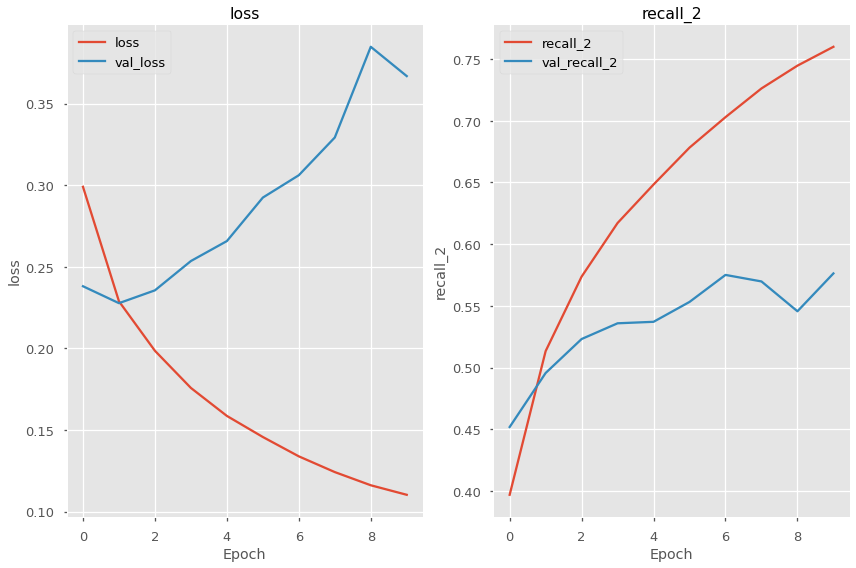

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.6092175556932998             *
********************************************************************************
********************************************************************************
*                                   F1_SCORE                                   *
********************************************************************************
F1 Score:        0.6092175556932998
Hamming Loss:    0.08862870838191475
Recall Score:    0.6400566371588982
Precision Score: 0.6765281766642047


In [69]:
# model_history = model.fit(X_train_tok, 
#                           dw.Y_train(), 
#                           epochs=10, 
#                           batch_size=32, 
#                           validation_data=(X_val_tok, 
#                                            dw.Y_val()))

# dis.plot_history(model_history,
#                  [x for x in model_history.history.keys()
#                   if not x.startswith('val')])

# # Find optimal prediction threshold.
# y_val_pred = model.predict(X_val_tok)

# dis.fit_thresholds(dw.Y_val(), y_val_pred, 'f1_score')

```
********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.6092175556932998             *
********************************************************************************
********************************************************************************
*                                   F1_SCORE                                   *
********************************************************************************
F1 Score:        0.6092175556932998
Hamming Loss:    0.08862870838191475
Recall Score:    0.6400566371588982
Precision Score: 0.6765281766642047
```

<img src='./images/test.png'>

#### Keras Tuner - Hyperband

In [ ]:
RUN_TUNER = False

In [ ]:
if RUN_TUNER:
    keras_tuner_dir = './models/keras_tuner'
    
    tuner = dis.keras_tuner_hyperband(X_train_tok,
                                      dw.Y_train(),
                                      X_val_tok, 
                                      dw.Y_val(),
                                      directory=keras_tuner_dir)
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.fit(X_train_tok, 
              dw.Y_train(), 
              epochs=10, 
              batch_size=32, 
              validation_data=(X_val_tok, 
                               dw.Y_val()))

```
********************************************************************************
*                               Tuning Complete                                *
********************************************************************************
Optimal Settings:
	GRU UNITS           : 224
	DENSE UNITS         : 416
	LEARNING RATE       : 0.001
    ```

In [ ]:
GRU_UNITS = 224
DENSE_UNITS = 416
LEARNING_RATE = 0.001

In [ ]:
# Build optimal model.
gru_tuned_model = dis.build_model(num_words, 
                                  embedding_size,
                                  gru=True,
                                  gru_units=GRU_UNITS,
                                  dense_units=DENSE_UNITS,
                                  learning_rate=LEARNING_RATE)
gru_tuned_model.summary()

In [ ]:
TRAIN_GRU_TUNED = False

In [ ]:
gru_tuned_checkpoint_path = "models/model_callbacks/gru_tuned/cp.ckpt"
gru_tuned_checkpoint_dir = os.path.dirname(gru_tuned_checkpoint_path)

if TRAIN_GRU_TUNED:
    # Create a callback that saves the model's weights
    gru_tuned_callback = ModelCheckpoint(filepath=gru_tuned_checkpoint_path,
                                         save_weights_only=True,
                                         verbose=1)

    gru_tuned_model_history = gru_tuned_model.fit(
        X_train_tok, 
        dw.Y_train(), 
        epochs=5, 
        batch_size=32, 
        validation_data=(X_val_tok, dw.Y_val()),
        callbacks=[gru_tuned_callback])

elif os.listdir(gru_tuned_checkpoint_dir):
    # Load in pretrained weights.
    gru_tuned_model.load_weights(gru_tuned_checkpoint_path)

In [ ]:
# Find optimal prediction threshold.
y_val_pred = gru_tuned_model.predict(X_val_tok)

dis.fit_thresholds(dw.Y_val(), y_val_pred, 'f1_score')

## Deployment

> - "How did you pick the question(s) that you did?"
- "Why are these questions important from a business perspective?"
- "How did you decide on the data cleaning options you performed?"
- "Why did you choose a given method or library?"
- "Why did you select these visualizations and what did you learn from each of them?"
- "Why did you pick those features as predictors?"
- "How would you interpret the results?"
- "How confident are you in the predictive quality of the results?"
- "What are some of the things that could cause the results to be wrong?"

In [ ]:
# TESTING STUFF